# We have three variables: weather, lateness, traffic

weather = 0 good weather, 1 bad weather

traffic = 0 light traffic, 1 heavy traffic

lateness = 0 not late, 1 late

Directed Acyclic Graph:

Weather --> Traffic --> Lateness

In [6]:
import networkx
import numpy as np
import pandas as pd

from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.models import BayesianNetwork

import networkx as nx
import matplotlib.pyplot as plt


UsageError: Line magic function `%%matplotlib` not found.


In [7]:
df = pd.read_csv("data.csv")

In [8]:
## Learn the structure of the Bayesian Network (output: edges)

hc = HillClimbSearch(df) # initialization of the search process
best_model = hc.estimate(scoring_method = BicScore(df)) 

'''
1. Start with an empty graph
2. Compute initial BIC (Bayesian Information Criterion)
3. Add first edge
- Say the first edge is W -> T, compute the BIC, if it improved, keep the edge, otherwise, remove the edge
4. Continue edge modifications ( at each step, evaluate the BIC)
5. Go through all possibilities of different edge combinations
'''

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [9]:
best_model.edges()

OutEdgeView([('Weather', 'Traffic'), ('Traffic', 'Lateness')])

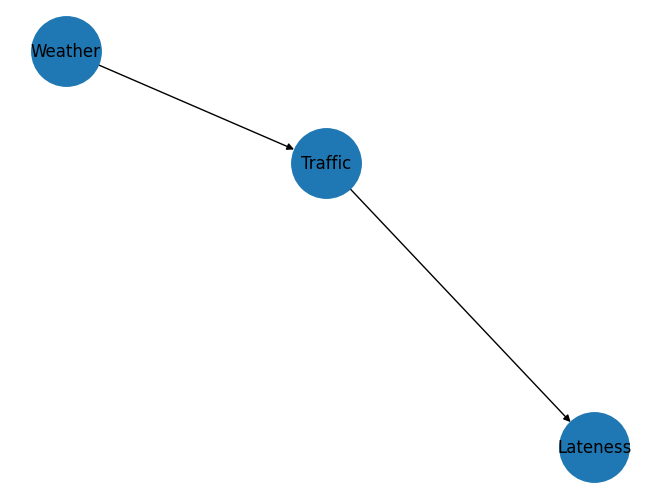

In [16]:
bn = BayesianNetwork(best_model.edges())

G = nx.DiGraph()
G.add_edges_from(bn.edges())

plt.figure()
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels = True, node_size = 2500)
plt.show()

In [18]:
from pgmpy.inference import VariableElimination

bn.fit(df)

inference = VariableElimination(bn)

In [21]:
result = inference.query(

    variables = ['Lateness'],
    evidence = {"Weather": 0,
               "Traffic": 0}
)
print(result)

# phi denotes the score of the model

+-------------+-----------------+
| Lateness    |   phi(Lateness) |
+=============+=================+
| Lateness(0) |          0.7726 |
+-------------+-----------------+
| Lateness(1) |          0.2274 |
+-------------+-----------------+


In [32]:
size = 1000

# Generate Season data (0: winter, 1: spring, 2: summer, 3: fall)
season = np.random.choice([0, 1, 2, 3], size=size)

# Generate Rain data (0: no rain, 1: rain)
# Rain probability depends on Season
rain_prob = np.zeros(size)
rain_prob[season == 0] = 0.7  # Higher probability of rain in winter
rain_prob[season == 1] = 0.4  # Medium probability in spring
rain_prob[season == 2] = 0.1  # Low probability in summer
rain_prob[season == 3] = 0.5  # Medium-high probability in fall
rain = np.random.binomial(1, rain_prob)

# Generate Sprinkler data (0: off, 1: on)
# Sprinkler probability depends on Season
sprinkler_prob = np.zeros(size)
sprinkler_prob[season == 0] = 0.05  # Very low probability in winter
sprinkler_prob[season == 1] = 0.4   # Medium probability in spring
sprinkler_prob[season == 2] = 0.8   # High probability in summer
sprinkler_prob[season == 3] = 0.3   # Medium-low probability in fall
sprinkler = np.random.binomial(1, sprinkler_prob)

# Generate Wet Grass data (0: dry, 1: wet)
# Wet Grass probability depends on both Rain and Sprinkler
wet_grass_prob = np.zeros(size)
# Neither rain nor sprinkler -> low probability of wet grass
wet_grass_prob[(rain == 0) & (sprinkler == 0)] = 0.05
# Only sprinkler on -> medium probability of wet grass
wet_grass_prob[(rain == 0) & (sprinkler == 1)] = 0.7
# Only rain -> high probability of wet grass
wet_grass_prob[(rain == 1) & (sprinkler == 0)] = 0.8
# Both rain and sprinkler -> very high probability of wet grass
wet_grass_prob[(rain == 1) & (sprinkler == 1)] = 0.95
wet_grass = np.random.binomial(1, wet_grass_prob)

# Create a DataFrame with the generated data
data = pd.DataFrame({
    'Season': season,
    'Rain': rain,
    'Sprinkler': sprinkler,
    'WetGrass': wet_grass
})

In [34]:
hc = HillClimbSearch(data) # initialization of the search process
best_model = hc.estimate(scoring_method = BicScore(data)) 

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [35]:
best_model.edges()

OutEdgeView([('Season', 'Sprinkler'), ('Season', 'Rain'), ('Rain', 'WetGrass'), ('Sprinkler', 'WetGrass')])

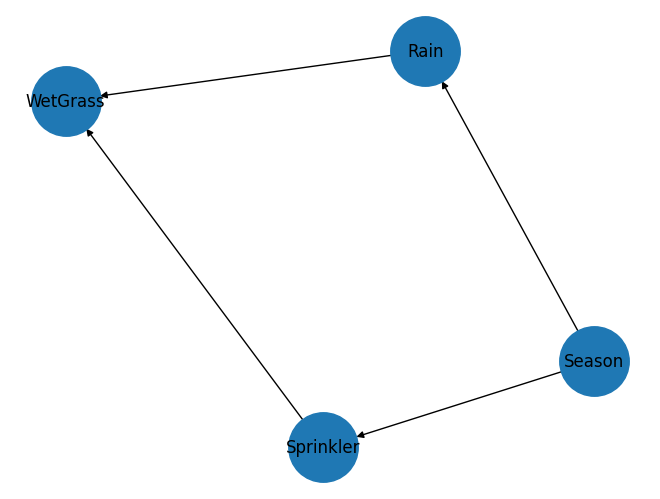

In [36]:
bn = BayesianNetwork(best_model.edges())

G = nx.DiGraph()
G.add_edges_from(bn.edges())

plt.figure()
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels = True, node_size = 2500)
plt.show()

In [38]:
from pgmpy.inference import VariableElimination

bn.fit(data)

inference = VariableElimination(bn)

In [45]:
result = inference.query(

    variables = ['WetGrass'],
    evidence = {"Rain": 1,
               "Sprinkler": 1,
               "Season": 0}
)
print(result)

# phi denotes the score of the model

+-------------+-----------------+
| WetGrass    |   phi(WetGrass) |
+=============+=================+
| WetGrass(0) |          0.0374 |
+-------------+-----------------+
| WetGrass(1) |          0.9626 |
+-------------+-----------------+
